In [1]:
import numpy as np 
import pandas as pd 

from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
import urllib
import requests
import json
from datetime import datetime,timedelta
import xmltodict # 결과가 xml 형식으로 반환된다. 이것을 dict 로 바꿔주는 라이브러리다

import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 브라우저에서 바로 그려지도록 
%matplotlib inline
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

## 코로나 공공데이터 불러오기

In [2]:
start_date = '20200101'
end_date = datetime.today().strftime("%Y%m%d")

my_api_key = 'P6ELThVVcjDdxzKGrTQlvsBqBrVUl3jUo1p%2B6yaTuOdR4Mrw%2F7UNBRnkRKlR7vBmPWs4LksNPBKxvvD4ts8LgA%3D%3D'

# 서비스 url 주소
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'

# 서비스에 필요한 파라미터 모음
queryParams = '?' + \
'ServiceKey=' + '{}'.format(my_api_key) + \
'&pageNo='+ '1' + \
'&numOfRows='+ '999' + \
'&startCreateDt={}&endCreateDt={}'.format(start_date, end_date)

#서비스url에 필요한 파라미터들을 붙여서 응답결과를 얻음.
result = requests.get(url + queryParams)

# 응답결과 파싱하기. ( 사용자가 원하는 형태로 변경)
# 응답 key 값이 영문화 되어 식별이 어려워 openAPI 문서를 참고하여
# replace 를 통해 결과를 한글화 했다.

result = result.content 
jsonString = json.dumps(xmltodict.parse(result), indent = 4)
jsonString = jsonString.replace('resultCode', '결과코드').replace('resultMsg', '결과메세지').replace('numOfRows', '한 페이지 결과 수').replace('pageNo', '페이지 수').replace('totalCount', '전체 결과 수').replace('seq', '게시글번호').replace('stateDt', '기준일').replace('stateTime', '기준시간').replace('decideCnt', '누적 확진자 수').replace('deathCnt', '누적 사망자 수').replace('accExamCnt', '누적 의심신고 검사자 수').replace('accDefRate', '누적 확진률').replace('createDt', '등록일시분초').replace('updateDt', '수정일시분초')
js = json.loads(jsonString)

# 파싱한 전체 결과 보기.
js_check_count = js["response"]['body']['items']['item'][0]['누적 확진자 수']
js = js["response"]['body']['items']['item']
corona_df = pd.DataFrame(js)
corona_df.head(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률
0,19082135,2021-12-27 08:59:50.623,5300,611670,740,20211227,00:00,null,NaN
1,19040194,2021-12-26 07:59:54.187,5245,607463,739,20211226,00:00,null,NaN


In [3]:
corona_df.tail(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률
704,15,2020-01-21 09:00:00.000,0,1,2,20200121,09:00,2021-10-07 10:30:51.51,6.666666667
705,4,2020-01-20 17:00:00.000,0,1,1,20200120,17:00,2021-10-07 10:30:51.51,25


> 데이터 기간: 2020년 01월 20일부터 첫 확진자가 생겼으며, 오늘(ex. 2021년 12월 26일)까지의 데이터를 가져온다.

In [4]:
corona_df.shape

(706, 9)

In [5]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   누적 의심신고 검사자 수  706 non-null    object
 1   등록일시분초         706 non-null    object
 2   누적 사망자 수       706 non-null    object
 3   누적 확진자 수       706 non-null    object
 4   게시글번호          706 non-null    object
 5   기준일            706 non-null    object
 6   기준시간           706 non-null    object
 7   수정일시분초         706 non-null    object
 8   누적 확진률         673 non-null    object
dtypes: object(9)
memory usage: 49.8+ KB


**데이터 설명**
- ```의심신고 검사자 수```: 의심환자 신고 후 검사를 진행한 건수(결과 양성(신규 확진자 수)+결과 음성+검사 중)로서 중복 검사 건수는 포함하지 않음
- ```확진율```: 확진/검사완료


In [6]:
print("누적 확진률 null값 기간: {} ~ {}".format(corona_df[corona_df['누적 확진률'].isna()]['기준일'].min(), corona_df[corona_df['누적 확진률'].isna()]['기준일'].max()))

누적 확진률 null값 기간: 20211124 ~ 20211227


> 최근 한달 간의 누적 확진률 데이터가 누락돼 있다. (20211124 ~ 20211227)

In [7]:
len(corona_df['기준일'].unique()) # 중복 일자는 없음

706

## 전처리

In [8]:
date = []
year = []
month = []
day = []

for data in corona_df['등록일시분초']:
    date.append(data.split()[0][:-3])
    year.append(data.split()[0].split('-')[0])
    month.append(data.split()[0].split('-')[1])
    day.append(data.split()[0].split('-')[2])

In [9]:
corona_df['year_month'] = date
corona_df['year'] = year
corona_df['month'] = month
corona_df['day'] = day

corona_df['year'] = corona_df['year'].astype('int64')
corona_df['month'] = corona_df['month'].astype('int64')
corona_df['day'] = corona_df['day'].astype('int64')
corona_df['누적 사망자 수'] = corona_df['누적 사망자 수'].astype('int64')
corona_df['누적 확진자 수'] = corona_df['누적 확진자 수'].astype('int64')
corona_df['누적 의심신고 검사자 수'] = corona_df['누적 의심신고 검사자 수'].astype('int64')
# corona_df['누적 확진률'] = corona_df['누적 확진률'].astype('int64')

### 신규 확진자 수 구하기

In [10]:
corona_df['신규 확진자 수'] = corona_df['누적 확진자 수'] - corona_df['누적 확진자 수'].shift(periods=-1, fill_value=0)
corona_df.head(2)

,누적 의심신고 검사자 수,등록일시분초,누적 사망자 수,누적 확진자 수,게시글번호,기준일,기준시간,수정일시분초,누적 확진률,year_month,year,month,day,신규 확진자 수
0,19082135,2021-12-27 08:59:50.623,5300,611670,740,20211227,00:00,null,NaN,2021-12,2021,12,27,4207
1,19040194,2021-12-26 07:59:54.187,5245,607463,739,20211226,00:00,null,NaN,2021-12,2021,12,26,5419


### 필요없는 컬럼 제거

In [11]:
drop_col = ['등록일시분초', '게시글번호', '기준시간', '수정일시분초']
corona_dropped_df = corona_df.drop(drop_col, axis=1)
corona_dropped_df.head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
0,19082135,5300,611670,20211227,NaN,2021-12,2021,12,27,4207
1,19040194,5245,607463,20211226,NaN,2021-12,2021,12,26,5419


In [12]:
corona_dropped_df.columns

Index(['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수', '기준일', '누적 확진률', 'year_month',
       'year', 'month', 'day', '신규 확진자 수'],
      dtype='object')

### 누락 데이터 확인

In [13]:
corona_dropped_df.describe()

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,year,month,day,신규 확진자 수
count,7.060000e+02,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000
mean,6.364171e+06,1278.576487,117115.137394,2020.509915,6.631728,15.822946,866.388102
std,5.624442e+06,1128.355764,138294.657274,0.500256,3.359806,8.803680,1357.871240
min,4.000000e+00,0.000000,1.000000,2020.000000,1.000000,1.000000,0.000000
25%,1.433824e+06,289.500000,13566.250000,2020.000000,4.000000,8.000000,74.000000
50%,4.599900e+06,1063.500000,67008.000000,2021.000000,7.000000,16.000000,444.000000
75%,1.066336e+07,2024.750000,159141.500000,2021.000000,10.000000,23.000000,1070.750000
max,1.908214e+07,5300.000000,611670.000000,2021.000000,12.000000,31.000000,13658.000000


> 신규 확진자 수 max == 13,658 이므로 누락 여부 확인 필요

In [14]:
corona_dropped_df.iloc[np.argmax(corona_df['신규 확진자 수'], axis=-1):].head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
15,18084589,4252,517259,20211212,NaN,2021-12,2021,12,12,13658
16,17950721,4130,503601,20211210,NaN,2021-12,2021,12,10,6748


> 2021년 12월 11일의 데이터가 누락돼 있음.


In [15]:
corona_dropped_df.groupby(['year', 'month'])['day'].count()

year  month
2020  1        12
      2        29
      3        31
      4        30
      5        30
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       31
2021  1        31
      2        28
      3        31
      4        30
      5        31
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       26
Name: day, dtype: int64

In [16]:
corona_dropped_df[(corona_dropped_df['year']==2020) & (corona_dropped_df['month']==5)]['day'].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [17]:
corona_dropped_df[corona_dropped_df['기준일']=='20200514']

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수


In [18]:
corona_dropped_df[corona_dropped_df['기준일']=='20200513']

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
591,695920,259,10962,20200513,1.62078005,2020-05,2020,5,13,26


> 2020년 5월 14일의 데이터가 누락돼 있음.

### 누락 데이터 대체
[2020.05.14](http://ncov.mohw.go.kr/tcmBoardView.do?contSeq=354534#)

[2021.12.11](https://www.kdca.go.kr/upload_comm/syview/doc.html?fn=163918276218500.hwp&rs=/upload_comm/docu/0015/) 

질병관리청 자료를 통해 데이터 추가

In [19]:
corona_dropped_df.columns

Index(['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수', '기준일', '누적 확진률', 'year_month',
       'year', 'month', 'day', '신규 확진자 수'],
      dtype='object')

In [20]:
data = [(711484, 260, 10991, '20200514', np.nan,'2020-05', 2020, 5, 14, 29),
        (17950721+73682, 4210, 510583, '20211211', np.nan, '2021-12', 2021, 12, 11, 6977)]

In [21]:
add_df = corona_dropped_df.append(pd.DataFrame(data, columns=corona_dropped_df.columns))
add_df.sort_values(by='누적 확진자 수', inplace=True)
add_df.reset_index(drop=True, inplace=True)

In [22]:
add_df.shape

(708, 10)

### 신규 검사자, 사망자, 확진자 구하기

In [23]:
add_df.head(2)

,누적 의심신고 검사자 수,누적 사망자 수,누적 확진자 수,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수
0,4,0,1,20200120,25,2020-01,2020,1,20,1
1,15,0,1,20200121,6.666666667,2020-01,2020,1,21,0


In [24]:
col_list = ['누적 의심신고 검사자 수', '누적 사망자 수', '누적 확진자 수']
for col in col_list:
    add_df['신규 {}'.format(col[-5:])] = add_df['{}'.format(col)] - add_df['{}'.format(col)].shift(periods=1, fill_value=0)

In [25]:
prep_df = add_df.drop(col_list, axis=1)
prep_df.head()

,기준일,누적 확진률,year_month,year,month,day,신규 확진자 수,신규 검사자 수,신규 사망자 수
0,20200120,25,2020-01,2020,1,20,1,4,0
1,20200121,6.666666667,2020-01,2020,1,21,0,11,0
2,20200122,4.761904762,2020-01,2020,1,22,0,6,0
3,20200123,4,2020-01,2020,1,23,0,4,0
4,20200124,6.896551724,2020-01,2020,1,24,1,4,0


## 시각화

### 월별 확진자 수

Text(0, 0.5, '확진자 수')

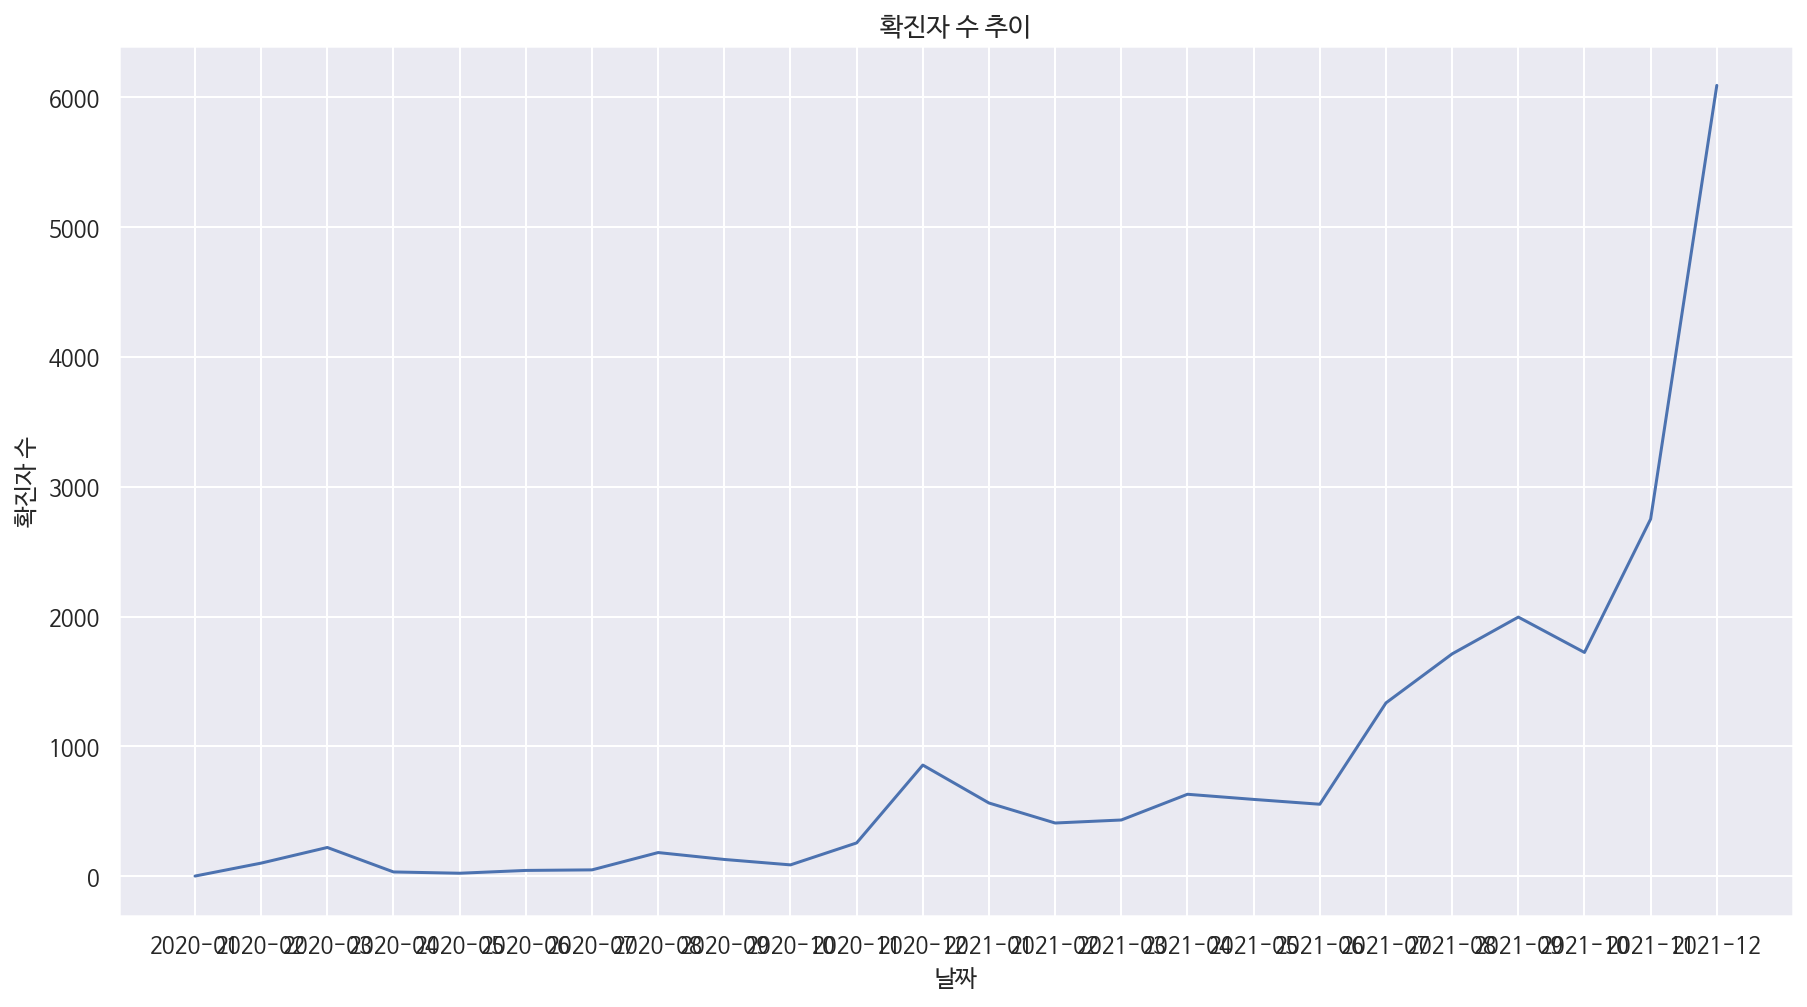

In [28]:
plt.rc('font', family='NanumBarunGothic') 

plt.figure(figsize=(15,8))

ax = sns.lineplot(prep_df["year_month"], prep_df["신규 확진자 수"], ci=None)
plt.title("확진자 수 추이", fontsize= 15)
plt.xlabel("날짜", fontsize= 12)
# plt.xticks(np.arange(0, 240, 10), labels=list(set(prep_df["year_month"])), rotation=45)
plt.ylabel("확진자 수", fontsize= 12)

In [29]:
# 데이터 변형
grp = prep_df.groupby(['year', 'month'])['신규 확진자 수'].sum()
confirmed_df = pd.DataFrame(grp).unstack().transpose()
confirmed_df = confirmed_df.droplevel(level=0)

In [30]:
confirmed_df.iplot(kind='line')

[Dash를 활용하여 Web Server 구현 방법](https://kibua20.tistory.com/212)